# Considerations for Activation Patching in IR

In our main demo notebook, we show an example for activation patching individual attention heads to demonstrate the workflow of an end-to-end pipeline. However, there are several factors to consider when designing activation patching experiments (see [Zhang and Nanda](https://arxiv.org/pdf/2309.16042) on best practices for activation patching for NLG tasks). Specifically, researchers should carefully consider (1) the type of perturbations used when creating input pairs for patching and (2) the evaluation metric used to assess patching results.

In this notebook, we provide an overview of the these "hyperparameters" in the context of activation patching in IR, along with some observational insights from our experiences. We leave empirical evaluation of these considertions for future work.

## Setup 

This section just installs the necessary packages to run the code in this notebook and also defines some helper functions for better readability and visualizations.

Just run, don't read :)

In [3]:
%pip install .. # TODO: replace with pip install mechir
%pip install transformer_lens
%pip install matplotlib seaborn plotly streamlit

Processing /Users/cchen207/git/brown/research/MechIR
  Preparing metadata (setup.py) ... done
  Created wheel for mechir: filename=mechir-0.0.1-py3-none-any.whl size=73244 sha256=dbe02ba69e89a4a2af0b3a3be6c4547cebd05e0f8bfcf0a5bdcda11ec884f4bb
  Stored in directory: /private/var/folders/w8/j9c1qwbx3cn8hf10x5nz_xtr0000gp/T/pip-ephem-wheel-cache-57r4d9wj/wheels/39/37/7c/9f04c1e8f880bc1e666f79cde17d9e585bcff18fdf2b5a9b0d
Successfully built mechir
  Attempting uninstall: mechir
    Found existing installation: mechir 0.0.1
    Uninstalling mechir-0.0.1:
      Successfully uninstalled mechir-0.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from mechir import Dot, MechIRDataset, DotDataCollator
from mechir.perturb import perturbation
from mechir.plotting import plot_components

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

/opt/anaconda3/envs/mechir/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-30 00:32:47.718 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


### Helper Functions

In [2]:
# Helper function to print query/baseline document/perturbed document triplets
def pretty_print_triplets(batch, tokenizer, num=1):
    """
    Pretty prints triplets of queries, documents, and their corresponding perturbed documents from a batch.

    Args:
        batch (dict): A dictionary containing 'queries', 'documents', and 'perturbed_documents' from a DataLoader.
        tokenizer: The tokenizer used to decode the input IDs.
        num (int): Number of examples to show per batch.
    """
    # Get the queries, documents, and perturbed documents from the batch
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]

    # Loop through number of examples to show in batch
    for i in range(len(documents["input_ids"][:num])):
        # Get the input IDs
        query_ids = queries["input_ids"][i]
        original_ids = documents["input_ids"][i]
        perturbed_ids = perturbed_documents["input_ids"][i]

        # Decode the input IDs to text
        query_decoded = tokenizer.decode(query_ids.tolist(), skip_special_tokens=False)
        original_doc_decoded = tokenizer.decode(original_ids.tolist(), skip_special_tokens=False)
        perturbed_doc_decoded = tokenizer.decode(perturbed_ids.tolist(), skip_special_tokens=False)

        # Pretty print
        # print(f"Triplet {i + 1}:")
        print("Query:", query_decoded)
        print("Baseline Document:", original_doc_decoded)
        print("Perturbed Document:", perturbed_doc_decoded)
        print("=" * 50)  # Separator for clarity

In [3]:
# Helper function to calculate and store performances
def calculate_performance(model, dataloader, baseline_performance, perturbed_performance):
    for i, batch in enumerate(dataloader):
        # Get the queries, documents, and perturbed documents from the batch
        queries = batch["queries"]
        documents = batch["documents"]
        perturbed_documents = batch["perturbed_documents"]

        # Encode queries, baseline, and perturbed documents
        queries_encoded = model._forward(**queries)  # [batch_size x hidden_dim]
        baseline_encoded = model._forward(**documents)  # [batch_size x hidden_dim]
        perturbed_encoded = model._forward(**perturbed_documents)  # [batch_size x hidden_dim]

        # Calculate scores
        baseline_scores = torch.sum(queries_encoded.unsqueeze(1) * baseline_encoded.unsqueeze(0), dim=2)
        perturbed_scores = torch.sum(queries_encoded.unsqueeze(1) * perturbed_encoded.unsqueeze(0), dim=2)

        # Append flattened scores to the performance lists
        baseline_performance += baseline_scores.flatten().tolist()
        perturbed_performance += perturbed_scores.flatten().tolist()

In [4]:
# Helper function to plot score distributions between baseline and perturbed documents
def plot_score_dists_mult(all_baseline_scores, all_perturbed_scores, plot_type="hist"):
    # Number of subplots (one per perturbation type)
    num_plots = len(all_baseline_scores)
    
    # Set up the figure to hold multiple subplots in a single row
    fig, axs = plt.subplots(1, num_plots, figsize=(15, 4), sharey=True)
    fig.suptitle('Distribution of Baseline vs Perturbed Scores', fontsize=16)
    
    for idx, (perturb_type, ax) in enumerate(zip(all_baseline_scores.keys(), axs)):
        baseline_scores = all_baseline_scores[perturb_type]
        perturbed_scores = all_perturbed_scores[perturb_type]
        
        if plot_type == "hist":
            ax.hist(baseline_scores, label='Baseline', color='blue', alpha=0.5, bins=15)
            ax.hist(perturbed_scores, label='Perturbed', color='orange', alpha=0.5, bins=15)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel('Frequency')
            ax.legend()
        elif plot_type == "kde":
            # Use seaborn for KDE plot, smoother distribution representation
            sns.kdeplot(baseline_scores, label='Baseline', color='#D55E00', fill=True, ax=ax, alpha=0.5)
            sns.kdeplot(perturbed_scores, label='Perturbed', color='#009E73', fill=True, ax=ax, alpha=0.5)
            ax.set_ylabel('Density')
            ax.legend()
        elif plot_type == "box":
            ax.boxplot([baseline_scores, perturbed_scores], tick_labels=['Baseline', 'Perturbed'])
            ax.set_ylabel('Scores')
        
        ax.set_xlabel('Scores')
        ax.set_title(f'{perturb_type.capitalize()}')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()

    return

## Accessing Model Activations

`MechIR` is built on top of [TransfomerLens](https://github.com/TransformerLensOrg/TransformerLens) and supports loading Transformer-based IR models from Huggingface (e.g., cross-encoders and bi-encoders). To do so, simply provide the Huggingface model name and initialize a `Cat`or `Dot` model with the model name. This will create a `HookedModel` instance that exposes the model's internal components via `HookPoints`.

NOTE: Our initial implementation is flexible enough to support loading a wide variety of Transformer-based IR models, but we have mainly tested the following models:
- TAS-B (bi-encoder) [[Hofstätter et al.]](https://arxiv.org/abs/2104.06967) [[HF model card]](https://huggingface.co/sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco)
- monoELECTRA (cross-encoder) [[Pradeep et al.]](https://link.springer.com/chapter/10.1007/978-3-030-99736-6_44) [[HF model card]](https://huggingface.co/crystina-z/monoELECTRA_LCE_nneg31)

In [5]:
# Bi-encoder model example
dot_model_name = "sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco"
dot_model = Dot(dot_model_name)

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco into HookedEncoder


*Note: a `HookedModel` essentially re-implements a model from scratch using the Huggingface config file, so there may be some slight differences in output values. We include a testing module (`/integration`) that you can use to test any custom models you may have. In particular, you will want to test (1) the weights have been loaded correctly from HuggingFace into the `HookedModel` and (2) the embeddings/outputs of the `HookedModel` are approximately the same as the HuggingFace model.*

## Paired Dataset Creation

Activation patching relies on pairs of inputs, consisting of one *perturbed* input and one *baseline* input, where the *perturbed* input is constructed by applying some function to modify an *original* input (e.g., inserting a query term to the end of a document) and the *baseline* input is a padded variant of the *original* input to maintain token lengths between the pairs.

In the main demo, we show one possible type of perturbation (appending a query term to the end of a document), but there are several other possible types of functions that could be use to generate the activation patching input pairs depending on what behavior you are trying to investigate. In this section, we discuss possible general perturbation methods, and describe some specific perturbations that we define aligning with IR axioms.

In [6]:
# For demonstration purposes, look at two queries
dataset = MechIRDataset("vaswani", query_id_subset=["1", "2"])
print("Number of query,doc pairs in dataset:", len(dataset))
print("Query:", dataset._get_query("1"))
print("Query:", dataset._get_query("2"))

Number of query,doc pairs in dataset: 34
Query: MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES

Query: MATHEMATICAL ANALYSIS AND DESIGN DETAILS OF WAVEGUIDE FED MICROWAVE RADIATIONS



The following are some possible methods for perturbing inputs to create the paired dataset:
- Append: injecting a term or set of terms to the beginning of a document.
- Prepend: injecting a term or set of terms to the end of a document.
- Replacement: replacing a term or set of terms with another term or set of terms.

Perturbations can be defined using the `perturb` module, as seen below:

In [7]:
# Define perturbations
@perturbation
def append(doc):
    return doc + " microwave"

@perturbation
def prepend(doc):
    return "microwave " + doc

@perturbation
def replace(doc):
    return doc.replace("microwave", "toaster")

Once your perturbations are defined, you can apply them to your dataset using a `DataCollator` and batch inputs using a `DataLoader`.

In [9]:
prepend_dot_collator = DotDataCollator(dot_model.tokenizer, prepend, q_max_length=None, d_max_length=None, perturb_type="prepend")
prepend_dot_dataloader = DataLoader(dataset, batch_size=16, collate_fn=prepend_dot_collator)

append_dot_collator = DotDataCollator(dot_model.tokenizer, append, q_max_length=None, d_max_length=None, perturb_type="append")
append_dot_dataloader = DataLoader(dataset, batch_size=16, collate_fn=append_dot_collator)

replace_dot_collator = DotDataCollator(dot_model.tokenizer, replace, q_max_length=None, d_max_length=None, perturb_type="replace")
replace_dot_dataloader = DataLoader(dataset, batch_size=16, collate_fn=replace_dot_collator)

Now, let's take a look at some examples of our input pairs! Note that in order to preserve token length between the baseline and perturbed document, we pad the shorter document with a filler token (i.e., 'X'). 

In [10]:
# Get a single pair from each perturbation type just to visualize
prepend_batch = next(iter(prepend_dot_dataloader))
append_batch = next(iter(append_dot_dataloader))
replace_batch = next(iter(replace_dot_dataloader))

print("PREPEND")
pretty_print_triplets(prepend_batch, dot_model.tokenizer, num=2)

print("\nAPPEND")
pretty_print_triplets(append_batch, dot_model.tokenizer, num=2)

print("\nREPLACE")
pretty_print_triplets(replace_batch, dot_model.tokenizer, num=2)

PREPEND
Query: [CLS] measurement of dielectric constant of liquids by the use of microwave techniques [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

#### Built-in Axiomatic Perturbations

We also support the following initial set of axiomatic perturbations, with plans to integrate more IR axioms in the future: 
- Term frequency (TFC1) [[Fang et al.]](https://dl.acm.org/doi/10.1145/1008992.1009004): documents with more occurrences of query terms should be ranked higher than documents with less
- Term discrimination constraint (TDC) [[Fang et al.]](https://dl.acm.org/doi/10.1145/1008992.1009004): documents with more discriminative terms should be ranked higher

### Verify Difference in Performance on Perturbed Pairs

Before we can finalize our paired dataset and proceedto the patching experiments, there's a couple things to check:
- Does the chosen perturbation even have an effect on model behavior?
- If yes, what is that effect? (i.e., Do the *baseline* or *perturbed* inputs have a higher relevance score on average?)

So first, let's calculate the performances of the three toy perturbations we defined earlier (prepend, append, replace) and plot their distributions.

In [11]:
# Initialize lists to store baseline and perturbed performances for each dataloader
all_baseline_performance = {"prepend": [], "append": [], "replace": []}
all_perturbed_performance = {"prepend": [], "append": [], "replace": []}

# Calculate performances for each perturbation_type
calculate_performance(dot_model, prepend_dot_dataloader, all_baseline_performance["prepend"], all_perturbed_performance["prepend"])
calculate_performance(dot_model, append_dot_dataloader, all_baseline_performance["append"], all_perturbed_performance["append"])
calculate_performance(dot_model, replace_dot_dataloader, all_baseline_performance["replace"], all_perturbed_performance["replace"])


Below, we can see that there are slight differences in the effect of different perturbations. The 'prepend' and 'append' perturbation result in a higher relevance score for the *perturbed* input compared to the *baseline* input, but the `replace` perturbation doesn't show a large difference in relevance scores, which might suggest that our chosen perturbation isn't ideal for activaiton patching.

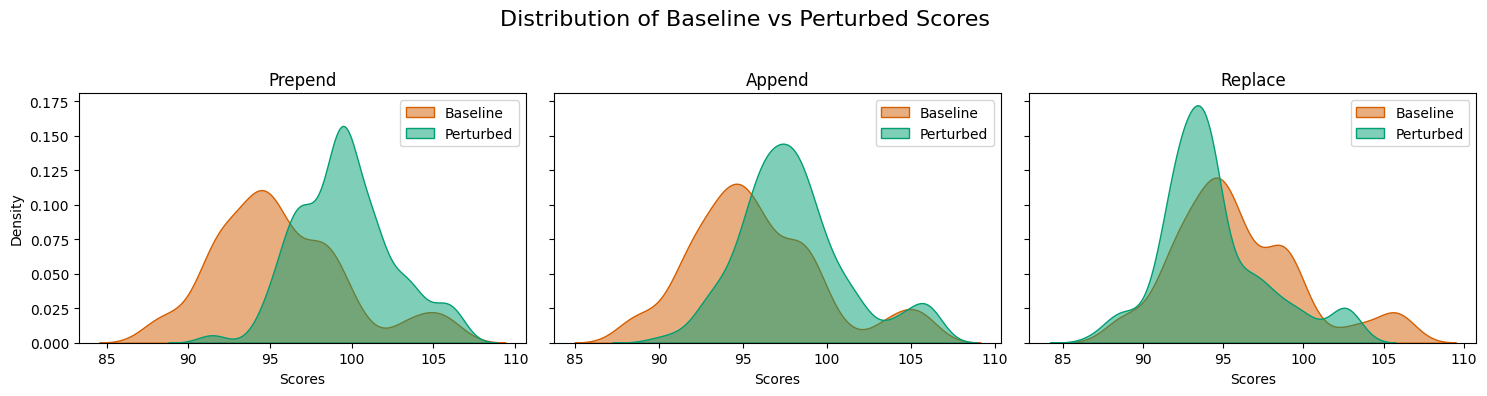

In [12]:
plot_score_dists_mult(all_baseline_performance, all_perturbed_performance, plot_type="kde")

While these are toy perturbations on a small set of input pairs, the takeaway here is that before you jump straight into activation patching, you should take careful consideration into what behavior you are trying to measure and how well your chosen perturbation captures that behavior.

## Activation Patching

### Setup and Evaluation

Activation patching consists of three forward passes through the model:
1. Baseline run
2. Perturbed run
3. Patched run

Remember in the previous section when we wanted to know the effect of the perturbation on the original input, specifically whether the *perturbed* or *baseline* input had the higher relevance score? Now that information will come into play, determining which "direction" we will perform activation patching, and what information we need to store in runs (1) and (2).

The "append" and "prepend" perturbations both caused an average higher relevance score on the original inputs. So our three runs will looks as follows:
1. Baseline run - run the model on the baseline inputs, recording the final relevance scores.
2. Perturbed run - run the model on the perturbed inputs, **caching the activations**, and recording the final relevance scores.
3. Patched run - run the model on the baseline inputs, **swapping in the cached activations from run (2) on components of interest**, and recording the final relevance scores.

To evaluate the effect of a patch and determine which component(s) are responsible for the difference in model behavior, we examine the final relevance scores from the patched run (3). The exact equation we use for the patching metric is shown below, but the intuition is as follows:
- If a component is important, then when we patch it in in run (3), the final relevance score should increase significantly toward the score on the perturbed run (2).
- If a component is not important, then it should not have any impact on the final relevance score when we patch it in in run (3), and the final relevance score would equal the score on the baseline run (1).

$$
\frac{\text{patched\_score} - \text{baseline\_score}}{\text{perturbed\_score} - \text{baseline\_score}}
$$

We normalize the metric such that a score of 0 indicates the patch had no effect (i.e., patched_score == baseline_score), a score of 1 indicates a significant component (i.e., patched_score == perturbed_score), and that a negative score indicates a negative component (i.e., patching in that component caused the relevance to decrease).

However, using the difference in relevance score is not the only choice we have for our patching evaluation metric. For activation patching on generative decoder-based language models, **logit difference** is often used as the evaluation metric, and thus, for IR models that use logits for the final relevance score (i.e., cross-encoders), we may want to consider using the difference in logits instead of difference in relevance scores.

🙋‍♀️🙋‍♂️ *How does the activation patching setup change if the perturbation causes a decrease in relevance score?*

In this scenario, we would swap the direction of our patch, and our three runs would look like this:
1. Baseline run - run the model on the baseline inputs, **caching the activations**, and recording the final relevance scores.
2. Perturbed run - run the model on the perturbed inputs, recording the final relevance scores.
3. Patched run - run the model on the **perturbed** inputs, **swapping in the cached activations from run (1) on components of interest**, and recording the final relevance scores.

and our patching evaluation metric like this:

$$
\frac{\text{patched\_score} - \text{perturbed\_score}}{\text{baseline\_score} - \text{perturbed\_score}}
$$

### Types of Patching

We support activation patching for the following components:
- Blocks: patches components (i.e., residual stream, attention outputs, MLP layer) across each individual token positions.
- Attention heads: patches individual attention heads in specific layers across all or individual token positions.

An example on how to perform activation patching on individual attention heads is shown below. To set the component to be patched, change the `patch_type` parameter.

In [13]:
patching_head_outputs = []
for i, batch in enumerate(append_dot_dataloader):
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]

    patch_head_out = dot_model(queries, documents, queries, perturbed_documents, patch_type="head_all")
    patching_head_outputs.append(patch_head_out)

mean_head_outputs = torch.mean(torch.stack(patching_head_outputs), axis=0)

TypeError: Dot.__call__() got multiple values for argument 'patch_type'

In [14]:
# Batch size of 16
plot_components(mean_head_outputs.detach().to("cpu").numpy())

NameError: name 'mean_head_outputs' is not defined

## Case Study
- more in depth experimental analysis from demo experiment?

## Limitations and Conclusion
- note that this is an indirect causal effect, support for direct causal effect (i.e., path patching) will come in the future
- overview and hopes for future research
- pointers to relevant literature/tutorials/resources